# Iterating, Tuning Hyper-Parameters and Testing Advanced Features

## Key Revisions to the Strategic Framework

1. Feature Engineering Becomes a Cycle of Creation and Pruning

2. Robust, API-Ready Validation is Non-Negotiable.

3. Targeted, Metric-Driven Hyperparameter Tuning.

4. Modular, Interpretable Code.

## Setup and Load Data

In [2]:
#### TEMPORARY
import sys
sys.path.append('/home/bac/code/kaggle/kaggle-cmi-detect-behavior/')

In [11]:
import pandas as pd
import numpy as np
import os
import catboost as cat
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# --- Pathing and Experiment Tracking Setup ---
from src.tracking import ExperimentTracker
from src.config import DATA_PATH, PROJECT_PATH, USE_WANDB, WANDB_PROJECT, WANDB_ENTITY

tracker = ExperimentTracker(
    project_path=os.path.expanduser(PROJECT_PATH),
    use_wandb=USE_WANDB,
    wandb_project_name=WANDB_PROJECT,
    wandb_entity=WANDB_ENTITY
)

SEED = 42

In [4]:
# Load the raw data and create helper maps
train_sensor = pd.read_csv(os.path.join(os.path.expanduser(DATA_PATH), 'train.csv'))
train_demos = pd.read_csv(os.path.join(os.path.expanduser(DATA_PATH), 'train_demographics.csv'))
train_df = pd.merge(train_sensor, train_demos, on='subject', how='left')
metadata = train_df[['gesture', 'sequence_type']].drop_duplicates()
gesture_to_seq_type_map = metadata.set_index('gesture')['sequence_type'].to_dict()
gesture_map = {label: i for i, label in enumerate(metadata['gesture'].unique())}
inv_gesture_map = {i: label for label, i in gesture_map.items()}

## Pipeline Components

Major components which have been used to train the model baseline thusfar will be encapsulated in modular code.

1. Wave 4 feature generation
2. Competition metric
3. Model Training

**`NOTE` the model generates inconsistencies in the code following a strategic review. These errors need to be reviewed!! At present, these were spotted in the `create_wave4_features()` function.**

```python
def create_wave4_features(df):
    """
    Creates Wave-4 features: Adds demographic features to Wave 3a-PCA
    feature set.
    """
    
    ...
    for col in base_cols_to_agg + derived_cols_to_agg + tof_derived_cols_to_agg:
        aggs[col] = ['mean', 'std', 'min', 'max'] # FLAG

    phase_agg_df = df_feat.groupby(['sequence_id', 'phase']).agg(aggs)
    phase_agg_df.columns = ['_'.join(col).strip() for col in phase_agg_df.columns.values]
    phase_agg_df_unstacked = phase_agg_df.unstack(level='phase') # FLAG FILLNA
    phase_agg_df_unstacked.columns = ['_'.join(col).strip() for col in phase_agg_df_unstacked.columns.values]
    
    meta_df = df.groupby('sequence_id').first()
    final_df = pd.concat([meta_df[['subject', 'gesture'] + list(train_demos.columns[1:])], phase_agg_df_unstacked], axis=1).reset_index()
    
    # Create interaction features
    key_sensor_features = [
        'acc_mag_mean_Gesture', 'acc_mag_std_Gesture', 'jerk_mean_Gesture',
        'jerk_std_Gesture', 'tof_pca_0_mean_Gesture', 'tofl_invalid_pct_mean_Gesture'
    ]
    demographic_features = ['age', 'height_cm', 'shoulder_to_wrist_cm'] # flag
    
    for sensor_feat in key_sensor_features:
        for demo_feat in demographic_features:
            if sensor_feat in final_df.columns and demo_feat in final_df.columns:
                # Interaction by division (normalizing sensor reading by demographic)
                final_df[f'{sensor_feat}_div_{demo_feat}'] = final_df[sensor_feat] / (final_df[demo_feat] + 1e-6)
                # Ineraction by multiplication
                final_df[f'{sensor_feat}_mul_{demo_feat}'] = final_df[sensor_feat] * final_df[demo_feat]
    
    #final_df.drop(columns='subject', inplace=True)
    final_df['gesture_encoded'] = final_df['gesture'].map(gesture_map)
    
    print(f"Feature engineering complete. Shape of features: {final_df.shape}")
    return final_df
```

In [ ]:
def create_wave4n_features(df):
    """
    Creates Wave-4 features: Adds demographic features to Wave 3a-PCA
    feature set. With slight modifications below.
    """
    print("Starting Wave 4 (Interaction) Feature Engineering...")
    df_feat = df.copy()
    df_feat['acc_mag'] = np.sqrt(df_feat['acc_x']**2 + df_feat['acc_y']**2 + df_feat['acc_z']**2)
    df_feat['rot_mag'] = np.sqrt(df_feat['rot_w']**2 + df_feat['rot_x']**2 + df_feat['rot_y']**2 + df_feat['rot_z']**2)
    df_feat['jerk'] = df_feat.groupby('sequence_id')['acc_mag'].diff().fillna(0)
    for i in range(1, 5): 
        df_feat[f'thm_grad_{i}_{i+1}'] = df_feat[f'thm_{i}'] - df_feat[f'thm_{i+1}']
    
    tof_cols = [f'tof_{s}_v{p}' for s in range(1, 6) for p in range(64)]
    tof_data = df_feat[tof_cols].replace(-1, np.nan)
    df_feat['tof_invalid_pct'] = tof_data.isna().mean(axis=1)
    
    pca = PCA(n_components=10, random_state=SEED) 
    tof_pca_features = pca.fit_transform(tof_data.fillna(0))
    for i in range(10): 
        df_feat[f'tof_pca_{i}'] = tof_pca_features[:, i]
        
    base_cols_to_agg = [col for col in df.columns if 'acc_' in col or 'rot_' in col or 'thm_' in col]
    derived_cols_to_agg = [col for col in df_feat.columns if 'mag' in col or 'jerk' in col or 'grad' in col]
    tof_derived_cols_to_agg = ['tof_invalid_pct'] + [f'tof_pca_{i}' for i in range(10)]
    aggs = {}
    for col in base_cols_to_agg + derived_cols_to_agg: 
        aggs[col] = ['mean', 'std', 'min', 'max', 'skew'] # FLAG
    for col in tof_derived_cols_to_agg:
        aggs[col] = ['mean', 'std', 'min', 'max'] # FLAG
        
    phase_agg_df = df_feat.groupby(['sequence_id', 'phase']).agg(aggs)
    phase_agg_df.columns = ['_'.join(col).strip() for col in phase_agg_df.columns.values]
    phase_agg_df_unstacked = phase_agg_df.unstack(level='phase').fillna(0) # FLAG
    phase_agg_df_unstacked.columns = ['_'.join(col).strip() for col in phase_agg_df_unstacked.columns.values]
    
    meta_df = df.groupby('sequence_id').first()
    final_df = pd.concat([meta_df[['gesture'] + list(train_demos.columns)], phase_agg_df_unstacked], axis=1).reset_index()
    
    key_sensor_features = ['acc_mag_mean_Gesture', 'acc_mag_std_Gesture', 'jerk_mean_Gesture', 
                           'jerk_std_Gesture', 'tof_pca_0_mean_Gesture', 'tof_invalid_pct_mean_Gesture']
    demographic_features = ['age', 'height_cm', 'shoulder_to_wrist_cm', 'sex', 'elbow_to_wrist_cm'] # FLAG
    for sensor_feat in key_sensor_features:
        for demo_feat in demographic_features:
            if sensor_feat in final_df.columns and demo_feat in final_df.columns:
                final_df[f'{sensor_feat}_div_{demo_feat}'] = final_df[sensor_feat] / (final_df[demo_feat] + 1e-6)
                final_df[f'{sensor_feat}_mul_{demo_feat}'] = final_df[sensor_feat] * final_df[demo_feat]
                
    final_df['gesture_encoded'] = final_df['gesture'].map(gesture_map)
    print(f"Feature engineering complete. Shape of features: {final_df.shape}")
    
    return final_df

In [25]:
# Modified version to handle permutation importance calculations
def average_f1_score(y_true_encoded, y_pred_proba, inv_gesture_map, gesture_to_seq_type_map, **kwargs):
    """
    Calculates the official competition F1 score. The version is self contained and does not rely on global
    variables.
    
    Args:
        y_true_encoded: True labels, integer encoded.
        y_pred_proba: Predicted probabilities from the model.
    """
    # Get predicted labels by finding the class with the highest probability
    y_pred_encoded = np.argmax(y_pred_proba, axis=1)
    
    # Map integer-encoded labels back to the string representations
    y_true_str = pd.Series(y_true_encoded).map(inv_gesture_map)
    y_pred_str = pd.Series(y_pred_encoded).map(inv_gesture_map)
    
    # Binary F1
    y_true_binary = y_true_str.map(gesture_to_seq_type_map)
    y_pred_binary = y_true_str.map(gesture_to_seq_type_map)
    binary_f1 = f1_score(y_true_binary, y_pred_binary, pos_label='Target', 
                         average='binary', zero_division=0)
    
    # Macro F1 (collaped non-target class)
    def collapse_non_target(gesture):
        return 'non_target' if gesture_to_seq_type_map[gesture] == 'Non-Target' else gesture
    
    y_true_collapsed = y_true_str.apply(collapse_non_target)
    y_pred_collapsed = y_pred_str.apply(collapse_non_target)
    macro_f1 = f1_score(y_true_collapsed, y_pred_collapsed, average='macro',
                        zero_division=0)
    
    # Final score = average of the two components
    return (binary_f1 + macro_f1) / 2

In [31]:
def get_trained_model(X_train, y_train, X_val, y_val, params):
    """Trains a CatBoost model and returns the trained object."""
    model = cat.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)
    return model


def plot_feature_importance(model, feature_names, top_n=50):
    """Plots feature importance from a trained CatBoost model"""
    imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.get_feature_importance()
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, top_n / 2))
    sns.barplot(x='importance', y='feature', data=imp_df)
    plt.title(f'Top {top_n} Features (CatBoost Built-in Importance)')
    plt.tight_layout()
    plt.show()
    return imp_df

def calculate_permutation_importance(model, X_val, y_val, inv_map, seq_type_map, top_n=50):
    """Calculates and plots permutation importance"""
    print("Calculating permutation importance...")
    # Pass maps to scorer as kwargs to ensure they are available in the parallel worker process
    scorer = make_scorer(average_f1_score, 
                         needs_proba=True, 
                         inv_gesture_map=inv_map,
                         gesture_to_seq_type_map=seq_type_map)
    # The 'permutation_importance' from sklearn was being overwritten.
    # We now call it explicitly via its module 'sklearn.inspection' to be safe,
    # and assign the result to a non-conflicting variable name.
    import sklearn.inspection
    result = sklearn.inspection.permutation_importance(
        model, X_val, y_val, n_repeats=5, random_state=SEED, n_jobs=-1, scoring=scorer
    )
    
    perm_imp_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std,
    }).sort_values('importance_mean', ascending=False).head(top_n)
    
    print("Top 10 Permutation Importances:\n", perm_imp_df.head(10))
    
    plt.figure(figsize=(10, top_n / 2))
    plt.barh(
        perm_imp_df['feature'],
        perm_imp_df['importance_mean'],
        xerr=perm_imp_df['importance_std'],
        align='center'
    )
    plt.title(f'Top {top_n} Features (Permutation Importance on Validation Set)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return perm_imp_df

## Training Run for Feature Wave 4n

In [13]:
features_df = create_wave4n_features(train_df)

Starting Wave 4 (Interaction) Feature Engineering...
Feature engineering complete. Shape of features: (8151, 325)


In [14]:
# Setup training run and prep data
FEATURE_WAVE = "Wave 4n"
MODEL_NAME = "Catboost"
EXPERIMENT_NAME = f"{FEATURE_WAVE}-{MODEL_NAME}-CPU"
N_SPLITS = 5

# --- Model Parameters ---
params = {
    'iterations': 1000, 'learning_rate': 0.05, 'depth': 6,
    'loss_function': 'MultiClass', 'eval_metric': 'MultiClass',
    'random_seed': SEED, 'verbose': 0
}

# --- Prepare data for CV ---
X = features_df.drop(columns=['sequence_id', 'subject', 'gesture', 'gesture_encoded'])
y = features_df['gesture_encoded']
groups = features_df['subject']

In [15]:
# Train and evaluate.
fold_scores = []
cv = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = cat.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)
    
    # Predict on validation set
    val_preds_proba = model.predict_proba(X_val)
    
    # Evaluate fold performance using the official metric
    fold_score = average_f1_score(y_val, val_preds_proba)
    fold_scores.append(fold_score)
    print(f"Fold {fold+1} Competition F1 Score: {fold_score:.5f}")

# --- Final Score and Logging ---
mean_cv_score = np.mean(fold_scores)
print(f"\n--- CV Summary for {MODEL_NAME} ---")
print(f"Mean Competition F1 Score: {mean_cv_score:.5f}")
print(f"Std Dev: {np.std(fold_scores):.5f}\n")

tracker.log_experiment(
    experiment_name=EXPERIMENT_NAME, model_name=MODEL_NAME, feature_wave=FEATURE_WAVE,
    cv_score=mean_cv_score, params=params,
    notes="Evaluating Wave-4n baseline - Wave 3a+interaction features + flagged changes"
)

--- Fold 1/5 ---
Fold 1 Competition F1 Score: 0.83732
--- Fold 2/5 ---
Fold 2 Competition F1 Score: 0.78276
--- Fold 3/5 ---
Fold 3 Competition F1 Score: 0.80444
--- Fold 4/5 ---
Fold 4 Competition F1 Score: 0.78602
--- Fold 5/5 ---
Fold 5 Competition F1 Score: 0.79796

--- CV Summary for Catboost ---
Mean Competition F1 Score: 0.80170
Std Dev: 0.01947

Experiment 'Wave 4n-Catboost-CPU' logged to /home/bac/code/kaggle/kaggle-cmi-detect-behavior/experiment_log.csv


wandb: Currently logged in as: b-a-chaudhry (b-a-chaudhry-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


cv_score,▁
cv_score,0.8017
feature_wave,Wave 4n
model_name,Catboost


Experiment 'Wave 4n-Catboost-CPU' logged to W&B


## Feature and Permutation Importance for Pruning

In [32]:
# Training on one representative fold for feature analysis
cv_split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED).split(X, y, features_df['sequence_id'])
train_idx, val_idx = next(cv_split)

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

# Train model and get importances
print("Training a single model on fold 0 to analyze feature importance...")
model = get_trained_model(X_train, y_train, X_val, y_val, params)

Training a single model on fold 0 to analyze feature importance...


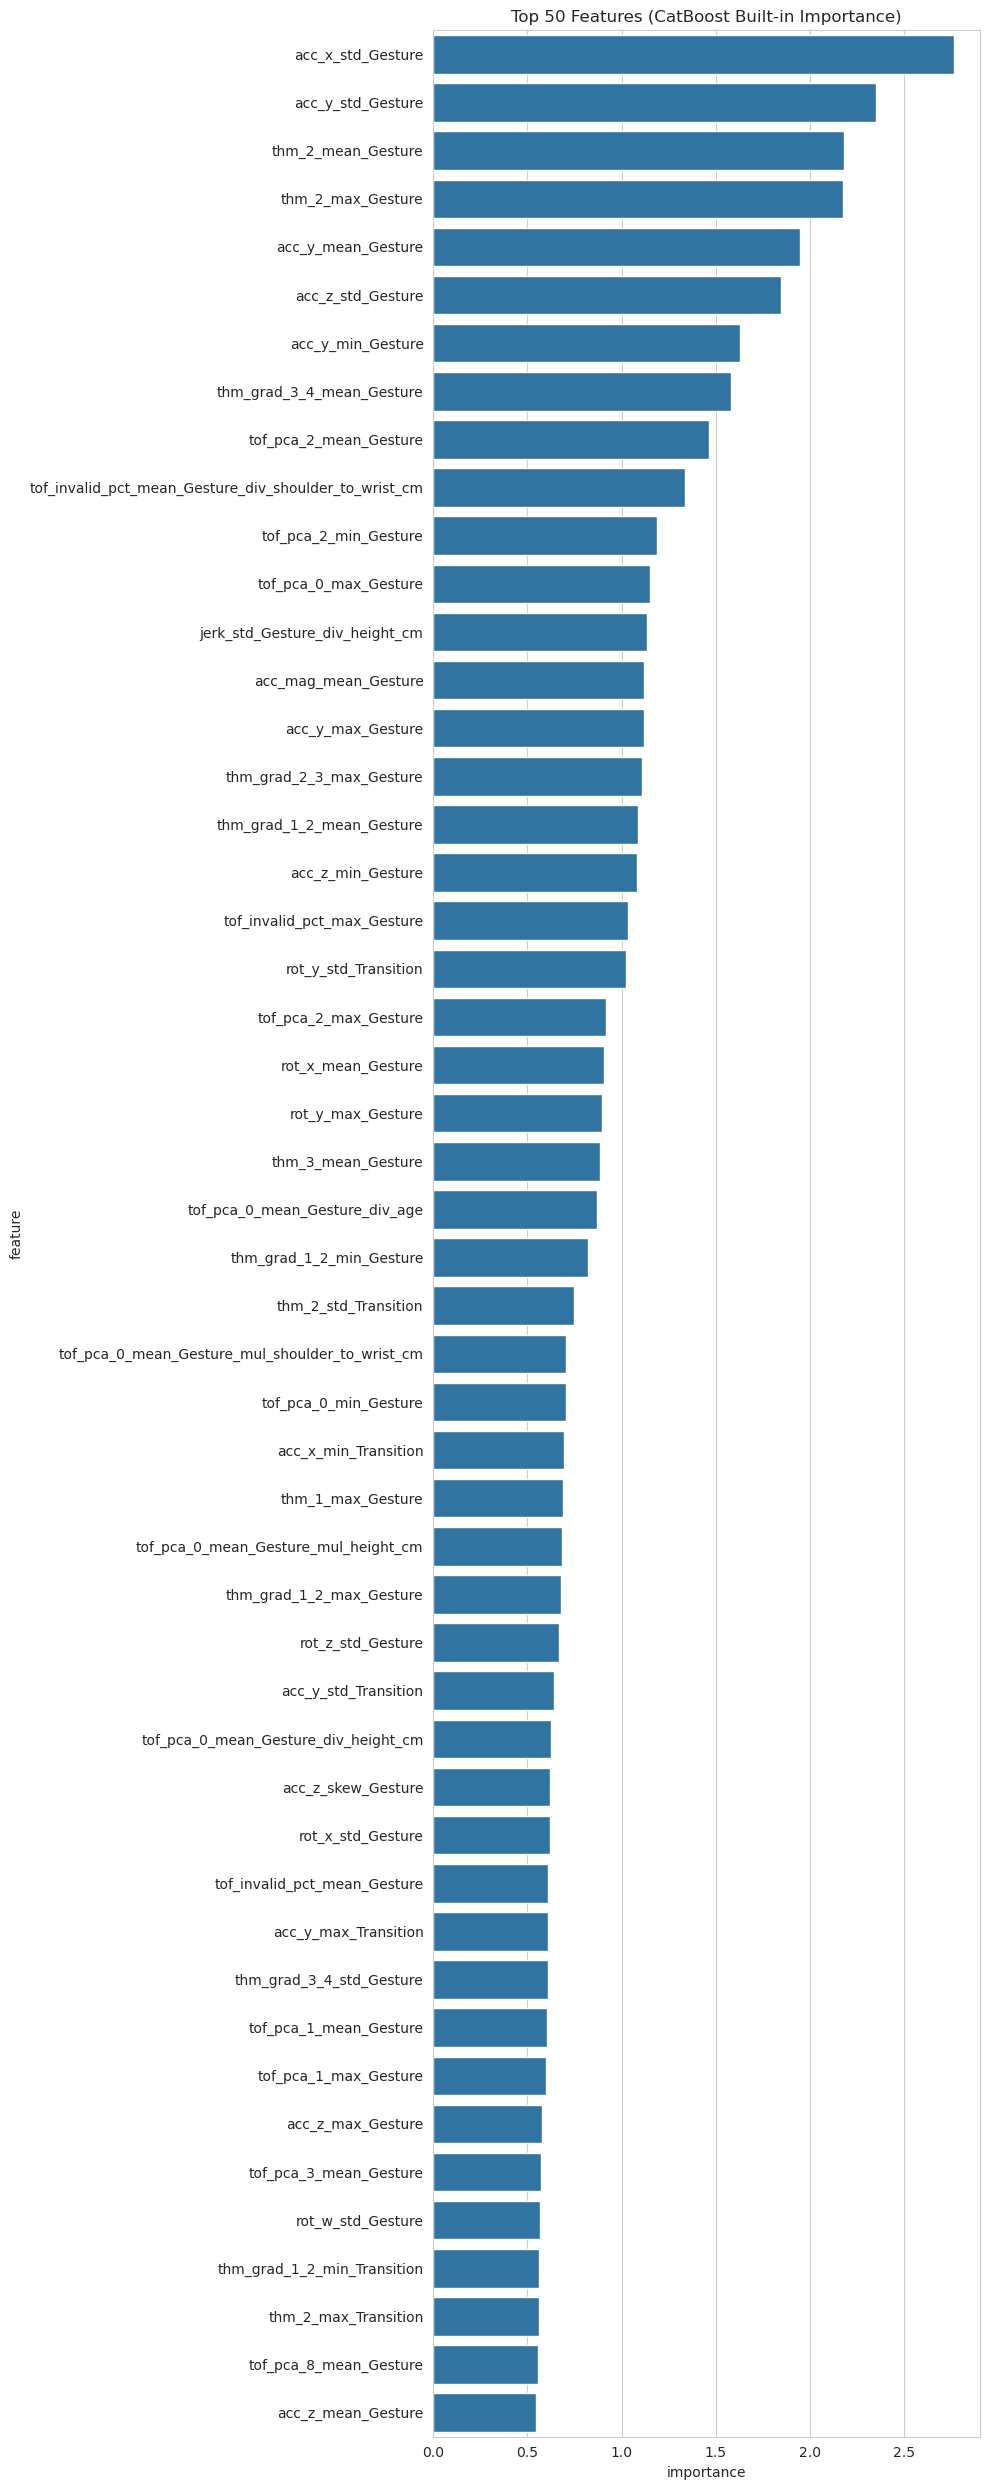

In [29]:
feat_importance = plot_feature_importance(model, X.columns)

Calculating permutation importance...
Top 10 Permutation Importances:
                                                feature  importance_mean  \
320  tof_invalid_pct_mean_Gesture_mul_shoulder_to_w...              0.0   
304                           jerk_std_Gesture_mul_age              0.0   
303                           jerk_std_Gesture_div_age              0.0   
302         jerk_mean_Gesture_mul_shoulder_to_wrist_cm              0.0   
301         jerk_mean_Gesture_div_shoulder_to_wrist_cm              0.0   
300                    jerk_mean_Gesture_mul_height_cm              0.0   
299                    jerk_mean_Gesture_div_height_cm              0.0   
298                          jerk_mean_Gesture_mul_age              0.0   
297                          jerk_mean_Gesture_div_age              0.0   
296       acc_mag_std_Gesture_mul_shoulder_to_wrist_cm              0.0   

     importance_std  
320             0.0  
304             0.0  
303             0.0  
302            

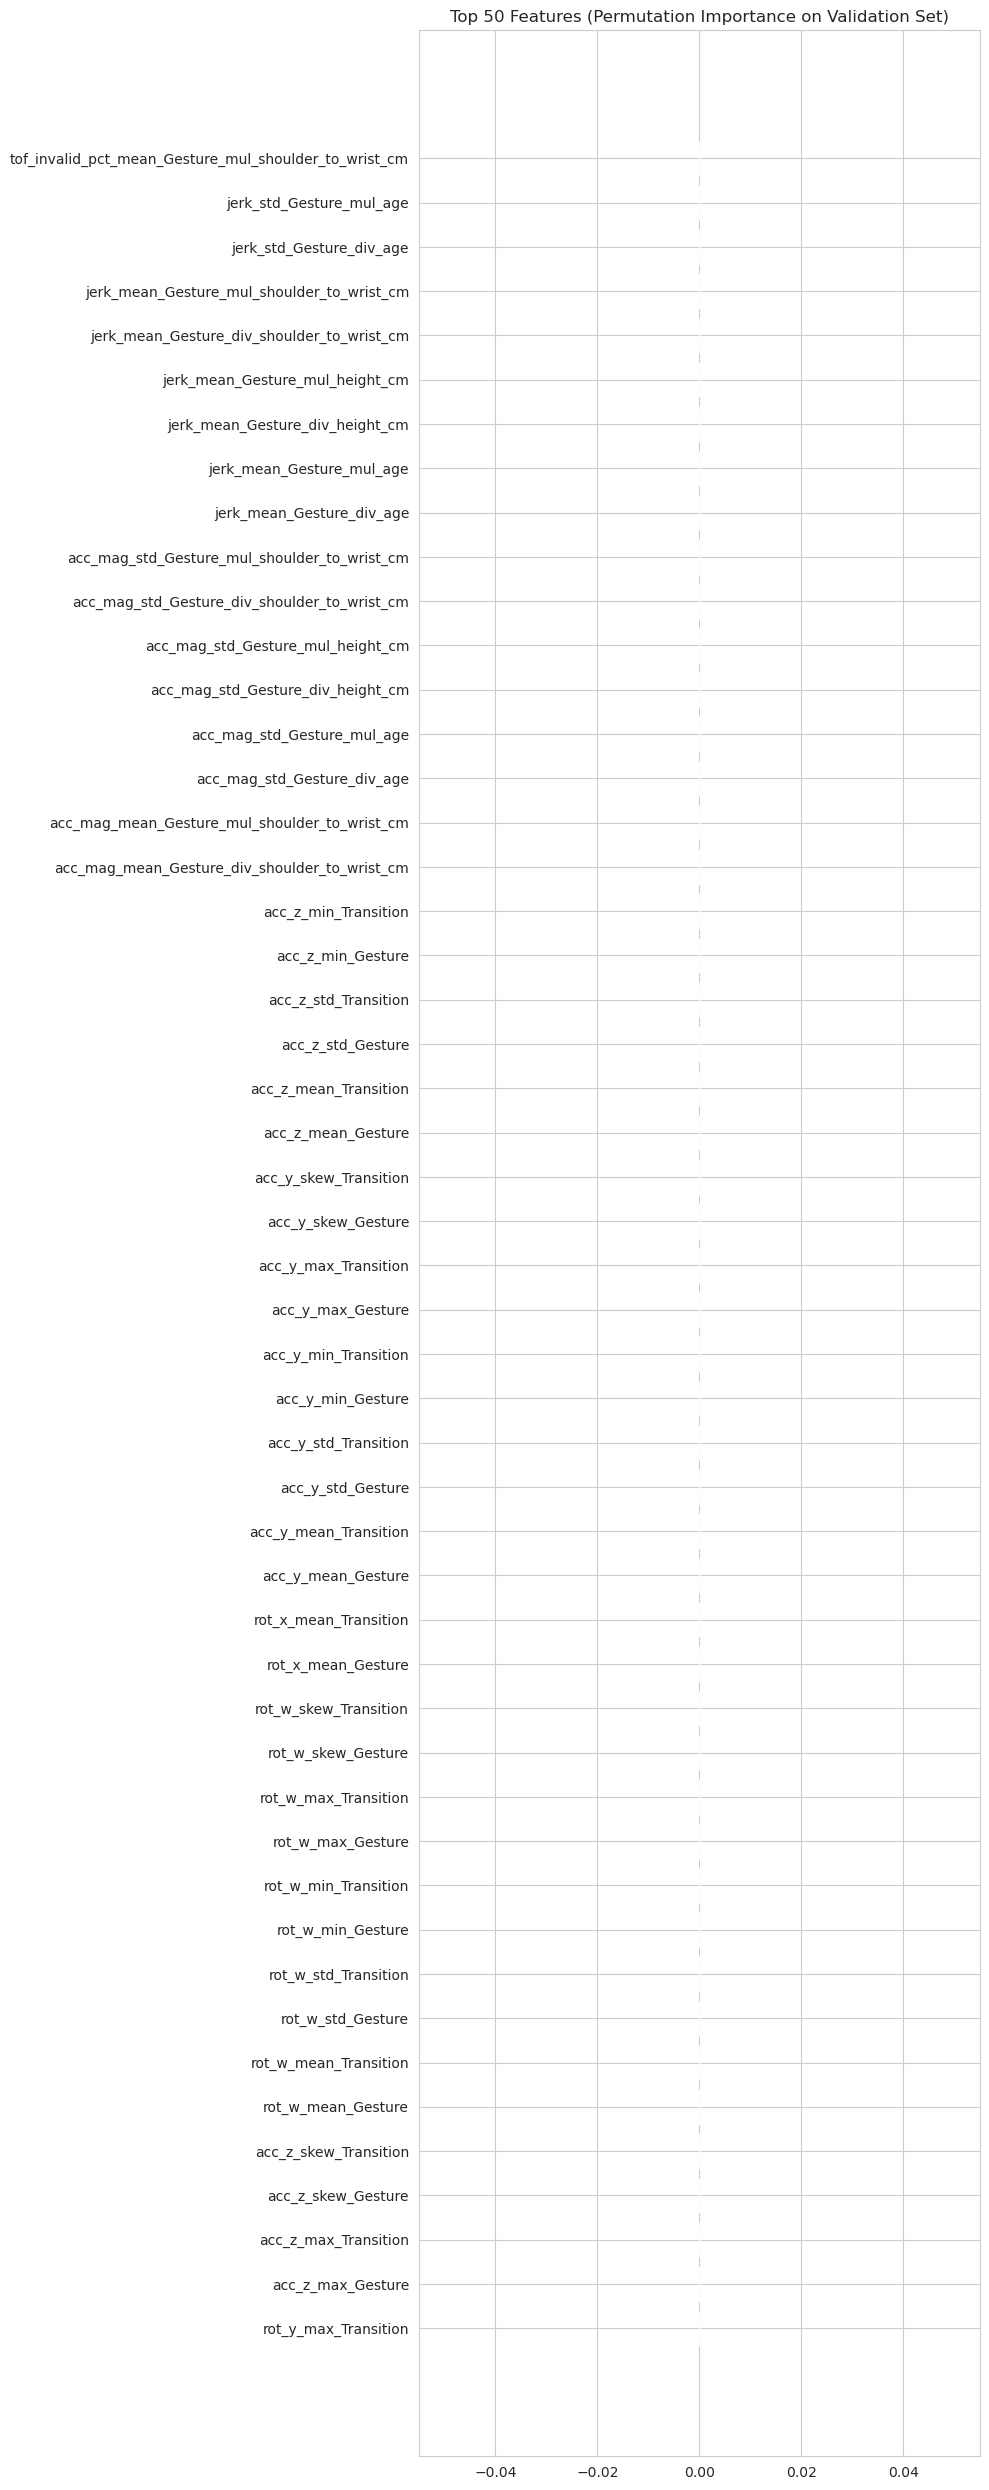

In [33]:
perm_importance_df = calculate_permutation_importance(model, X_val, y_val,
                                                   inv_map=inv_gesture_map,
                                                   seq_type_map=gesture_to_seq_type_map)